In [45]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import (
    balanced_accuracy_score,
    classification_report,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Random Seed
random_state = 33
np.random.seed(random_state)

In [4]:
# plt style
plt.style.use("seaborn-v0_8-darkgrid")

### Dataset

In [5]:
# Dataset
PROJECT_DIR = Path.cwd().parent

parq_path = PROJECT_DIR / "data" / "all_stats.parquet"
df = pd.read_parquet(parq_path)
df.head()


,flight_id,before_after,date_diff,flight_length,label,num_flights_before,volt1_mean,volt1_std,volt1_min,volt1_max,...,NormAc_p25,NormAc_p75,AltMSL_mean,AltMSL_std,AltMSL_min,AltMSL_max,AltMSL_range,AltMSL_p25,AltMSL_p75,AltMSL_rate_mean
0,1,before,-1,4723.0,intake gasket leak/damage,-1,28.780796,4.712894e-02,28.7,29.3,...,-0.01,0.01,2764.796803,1616.009723,835.6,5162.4,4326.8,842.55,4048.9,0.000275
1,2,before,-2,4649.0,intake gasket leak/damage,-2,27.831276,7.633934e-01,25.0,28.2,...,-0.03,0.04,2205.734739,1287.575722,824.1,5261.6,4437.5,887.00,3509.8,-0.001678
2,3,same,0,40.0,intake gasket leak/damage,0,24.900000,3.600403e-15,24.9,24.9,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,before,0,14.0,intake gasket leak/damage,0,25.400000,3.697782e-15,25.4,25.4,...,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,same,0,683.0,intake gasket leak/damage,0,26.945095,1.271312e+00,24.6,28.1,...,-0.02,0.02,832.528006,5.235779,812.9,846.0,33.1,831.60,835.4,0.031571


In [6]:
# add cluster (target) column
json_path = PROJECT_DIR / "data" / "label_cluster_map.json"
assert json_path.exists()

with json_path.open() as fp:
    label_cluster_map = json.loads(fp.read())

df["cluster"] = df["label"].map(label_cluster_map)

In [7]:
# weighted labels
sort_by = "weight_total_impact"

weighted_labels_path = PROJECT_DIR / "data" / "weighted_labels.csv"
weighted_labels_df = pd.read_csv(weighted_labels_path, index_col=0)
weighted_labels_df.sort_values(by=sort_by, ascending=False).head()

,label,count,cluster,price_usd,weight_norm,weight_total_impact,risk_factor,weight_risk_factor
7,engine run rough,670,c_24,839.99,0.383613,562793.30,1.4,27185.660955
3,baffle crack/damage/loose/miss,1294,c_4,419.95,0.237344,543415.30,1.3,34472.789022
9,engine failure/fire/time out,643,c_21,839.99,0.382277,540113.57,2.0,37271.599134
10,cylinder compression issue,617,c_13,795.00,0.362015,490515.00,1.7,29574.516259
17,oil cooler need maintenance,312,c_32,1189.00,0.513092,370968.00,1.4,15061.684878


In [8]:
# limit labels and apply filters
num_labels = 5

LABELS = weighted_labels_df.sort_values(by=sort_by, ascending=False)["label"].values[
    :num_labels
]
label_mask = df["label"].isin(LABELS)

# look only at flights before maintenance
before_mask = df["before_after"] == "before"

df_before = df[label_mask & before_mask]

#### Label Distribution

In [9]:
y_full = df_before["cluster"]
class_counts = y_full.value_counts().sort_index()
for cluster in class_counts.index:
    count = class_counts[cluster]
    pct = count / len(y_full) * 100
    print(f"{cluster=}, {pct=:0.2f}")

cluster=4, pct=35.93
cluster=13, pct=19.91
cluster=21, pct=15.56
cluster=24, pct=20.50
cluster=32, pct=8.11


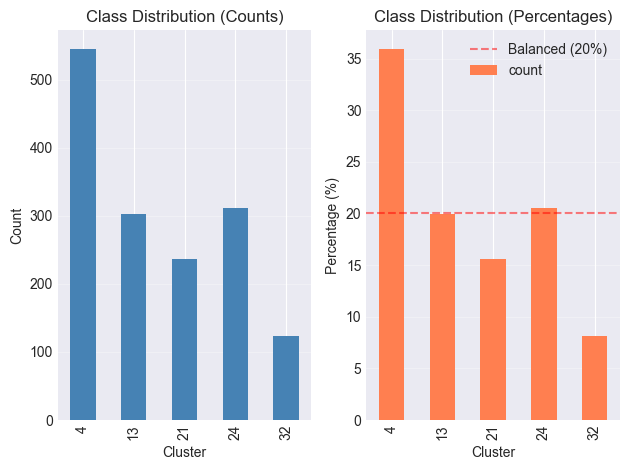

imbalance_ratio=4.43


In [10]:
# Visualize
fig, ax = plt.subplots(1, 2)
class_counts.plot(kind="bar", ax=ax[0], color="steelblue")
ax[0].set_title("Class Distribution (Counts)")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Count")
ax[0].grid(axis="y", alpha=0.3)

class_pcts = class_counts / len(y_full) * 100
class_pcts.plot(kind="bar", ax=ax[1], color="coral")
ax[1].set_title("Class Distribution (Percentages)")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Percentage (%)")
ax[1].axhline(y=20, linestyle="--", color="red", alpha=0.5, label="Balanced (20%)")
ax[1].legend()
ax[1].grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# imbalance ratio
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"{imbalance_ratio=:.2f}")

In [11]:
# Choose features for training
all_features = [
    "AltMSL_max",
    "AltMSL_mean",
    "AltMSL_min",
    "AltMSL_p25",
    "AltMSL_p75",
    "AltMSL_range",
    "AltMSL_rate_mean",
    "AltMSL_std",
    "E1_CHT1_max",
    "E1_CHT1_mean",
    "E1_CHT1_min",
    "E1_CHT1_p25",
    "E1_CHT1_p75",
    "E1_CHT1_std",
    "E1_CHT2_max",
    "E1_CHT2_mean",
    "E1_CHT2_min",
    "E1_CHT2_p25",
    "E1_CHT2_p75",
    "E1_CHT2_std",
    "E1_CHT3_max",
    "E1_CHT3_mean",
    "E1_CHT3_min",
    "E1_CHT3_p25",
    "E1_CHT3_p75",
    "E1_CHT3_std",
    "E1_CHT4_max",
    "E1_CHT4_mean",
    "E1_CHT4_min",
    "E1_CHT4_p25",
    "E1_CHT4_p75",
    "E1_CHT4_std",
    "E1_CHT_max_all",
    "E1_CHT_mean_all",
    "E1_CHT_min_all",
    "E1_CHT_rate_max",
    "E1_CHT_spread_mean",
    "E1_CHT_std_all",
    "E1_EGT1_max",
    "E1_EGT1_mean",
    "E1_EGT1_min",
    "E1_EGT1_p25",
    "E1_EGT1_p75",
    "E1_EGT1_std",
    "E1_EGT2_max",
    "E1_EGT2_mean",
    "E1_EGT2_min",
    "E1_EGT2_p25",
    "E1_EGT2_p75",
    "E1_EGT2_std",
    "E1_EGT3_max",
    "E1_EGT3_mean",
    "E1_EGT3_min",
    "E1_EGT3_p25",
    "E1_EGT3_p75",
    "E1_EGT3_std",
    "E1_EGT4_max",
    "E1_EGT4_mean",
    "E1_EGT4_min",
    "E1_EGT4_p25",
    "E1_EGT4_p75",
    "E1_EGT4_std",
    "E1_EGT_max_all",
    "E1_EGT_mean_all",
    "E1_EGT_min_all",
    "E1_EGT_rate_max",
    "E1_EGT_spread_mean",
    "E1_EGT_std_all",
    "E1_FFlow_max",
    "E1_FFlow_mean",
    "E1_FFlow_min",
    "E1_FFlow_p25",
    "E1_FFlow_p75",
    "E1_FFlow_std",
    "E1_OilP_mean",
    "E1_OilP_min",
    "E1_OilP_p25",
    "E1_OilP_p75",
    "E1_OilP_std",
    "E1_OilT_max",
    "E1_OilT_mean",
    "E1_OilT_min",
    "E1_OilT_p25",
    "E1_OilT_p75",
    "E1_OilT_rate",
    "E1_OilT_std",
    "E1_RPM_max",
    "E1_RPM_mean",
    "E1_RPM_min",
    "E1_RPM_p25",
    "E1_RPM_p75",
    "E1_RPM_std",
    "FQtyL_consumed",
    "FQtyL_end",
    "FQtyL_max",
    "FQtyL_mean",
    "FQtyL_min",
    "FQtyL_p25",
    "FQtyL_p75",
    "FQtyL_rate",
    "FQtyL_start",
    "FQtyL_std",
    "FQtyR_consumed",
    "FQtyR_end",
    "FQtyR_max",
    "FQtyR_mean",
    "FQtyR_min",
    "FQtyR_p25",
    "FQtyR_p75",
    "FQtyR_rate",
    "FQtyR_start",
    "FQtyR_std",
    "IAS_max",
    "IAS_mean",
    "IAS_min",
    "IAS_p25",
    "IAS_p75",
    "IAS_rate_mean",
    "IAS_std",
    "NormAc_max",
    "NormAc_mean",
    "NormAc_min",
    "NormAc_p25",
    "NormAc_p75",
    "NormAc_std",
    "OAT_max",
    "OAT_mean",
    "OAT_min",
    "OAT_p25",
    "OAT_p75",
    "OAT_std",
    "VSpd_max",
    "VSpd_mean",
    "VSpd_min",
    "VSpd_p25",
    "VSpd_p75",
    "VSpd_std",
    "amp1_max",
    "amp1_mean",
    "amp1_min",
    "amp1_p25",
    "amp1_p75",
    "amp1_std",
    "amp2_max",
    "amp2_mean",
    "amp2_min",
    "amp2_p25",
    "amp2_p75",
    "amp2_std",
    # "date_diff",
    # "flight_length",
    "fuel_imbalance_max",
    "fuel_imbalance_mean",
    # "num_flights_before",
    "volt1_max",
    "volt1_mean",
    "volt1_min",
    "volt1_p25",
    "volt1_p75",
    "volt1_std",
    "volt2_max",
    "volt2_mean",
    "volt2_min",
    "volt2_p25",
    "volt2_p75",
    "volt2_std",
]

In [25]:
# Split into X, y with all features
X_all = df_before[all_features].copy()
y_all = df_before["cluster"].copy()


le = LabelEncoder()
y_all_encoded = le.fit_transform(y_all)


# Remove rows with any NaN values
nan_mask = ~X_all.isna().any(axis=1)
X = X_all[nan_mask]
y = y_all_encoded[nan_mask]

# Check for NaN, inf
assert not X.isna().any().any()
assert not np.isinf(X).any().any()

### Train-Test Split

In [26]:
# train-test split with stratification
test_size = 0.20

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_size,
    random_state=random_state,
    stratify=y,
)

In [27]:
X_train.shape

(1054, 163)

In [28]:
X_train.isna().any().any()

np.False_

In [29]:
X_test.isna().any().any()

np.False_

### Feature Importance

#### F-Score

In [18]:
# f-stats - variance between means of different clusters
# higher f-value indicates greater effectiveness at separating cluster
f_scores, f_pvalues = f_classif(X_train, y_train)
f_scores_df = pd.DataFrame(
    {"feature": X_train.columns, "f_score": f_scores, "p_value": f_pvalues}
).sort_values("f_score", ascending=False)

print(f_scores_df.head(10))

          feature   f_score   p_value
100   FQtyL_start  7.525347  0.000006
94      FQtyL_max  7.414836  0.000007
0      AltMSL_max  7.167822  0.000011
130       OAT_std  7.127102  0.000012
5    AltMSL_range  7.061898  0.000013
7      AltMSL_std  7.035048  0.000014
1     AltMSL_mean  6.880226  0.000018
4      AltMSL_p75  6.747776  0.000023
104     FQtyR_max  6.186885  0.000064
146      amp2_p25  5.842406  0.000119


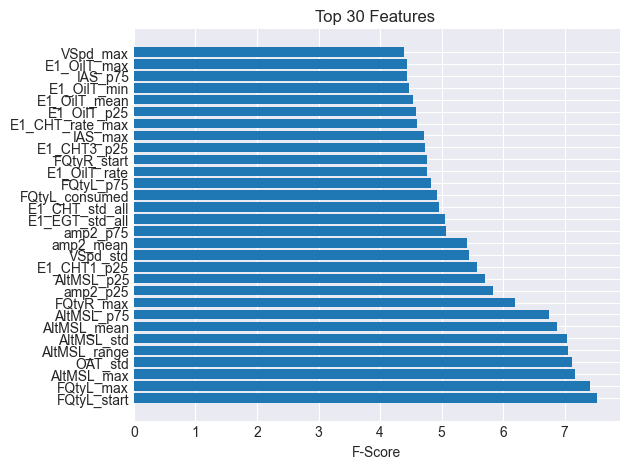

In [19]:
# Visualize top features
num_features = 30

top_df = f_scores_df.iloc[:num_features, :]
plt.barh(y=top_df["feature"], width=top_df["f_score"])

# f_scores_df.head(30).plot(x='feature', y='f_score', kind='barh', ax=ax, color='steelblue')
plt.title(f"Top {num_features} Features ")
plt.xlabel("F-Score")
plt.tight_layout()
plt.show()

#### Mutual Information

In [20]:
# Mutual Information - quantifies dependency between each individual feature X and target y
# Higher score indicate stronger dependency
mi_scores = mutual_info_classif(
    X_train, y_train, random_state=random_state, n_neighbors=5
)
mi_scores_df = pd.DataFrame(
    {"feature": X_train.columns, "mi_score": mi_scores}
).sort_values("mi_score", ascending=False)

print(mi_scores_df.head(10))


            feature  mi_score
144       amp2_mean  0.074308
140        amp1_p25  0.072776
29      E1_CHT4_p25  0.070655
9      E1_CHT1_mean  0.052019
126        OAT_mean  0.046774
23      E1_CHT3_p25  0.046680
94        FQtyL_max  0.044704
37   E1_CHT_std_all  0.044695
107       FQtyR_p25  0.044205
124      NormAc_std  0.043098


Text(0.5, 0, 'Mutual Information Score')

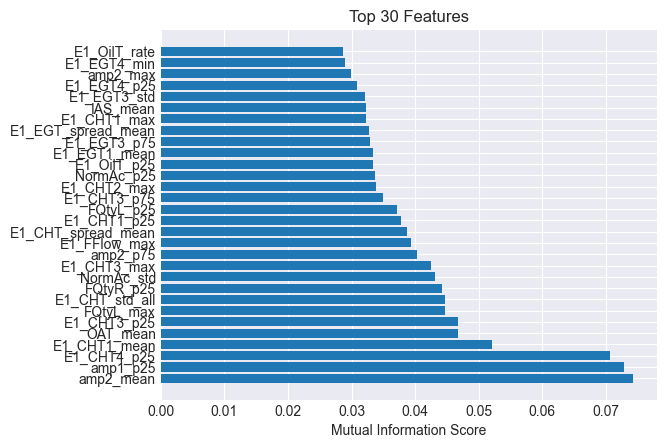

In [21]:
# Visualize top features
top_df = mi_scores_df.iloc[:num_features, :]

plt.barh(y=top_df["feature"], width=top_df["mi_score"])
plt.title(f"Top {num_features} Features")
plt.xlabel("Mutual Information Score")

#### Baseline Model Feature Importance

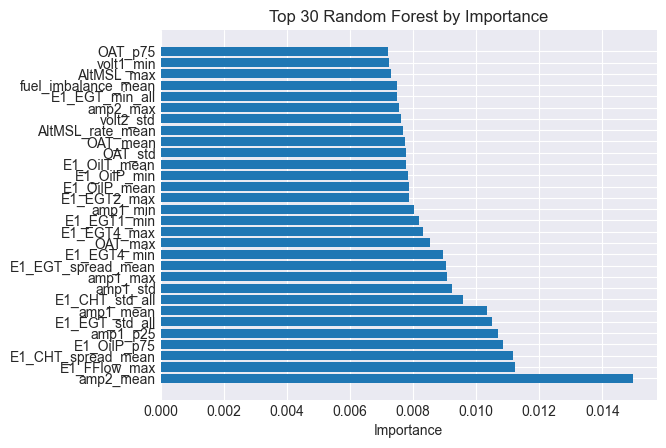

In [22]:
rf_baseline = RandomForestClassifier(
    n_estimators=100, class_weight="balanced", random_state=random_state, n_jobs=-1
)
rf_baseline.fit(X_train, y_train)

rf_importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": rf_baseline.feature_importances_}
).sort_values("importance", ascending=False)

# plot
top_df = rf_importance_df.iloc[:num_features, :]
plt.barh(y=top_df["feature"], width=top_df["importance"])
plt.title(f"Top {num_features} Random Forest by Importance")
plt.xlabel("Importance");

#### Combined Feature Ranking

In [23]:
combined_df = pd.DataFrame({"feature": X_train.columns})
combined_df = combined_df.merge(f_scores_df[["feature", "f_score"]], on="feature")
combined_df = combined_df.merge(mi_scores_df[["feature", "mi_score"]], on="feature")
combined_df = combined_df.merge(
    rf_importance_df[["feature", "importance"]], on="feature"
)
combined_df.head()

,feature,f_score,mi_score,importance
0,AltMSL_max,7.167822,0.018790,0.007291
1,AltMSL_mean,6.880226,0.022074,0.004994
2,AltMSL_min,0.492570,0.002076,0.005959
3,AltMSL_p25,5.708153,0.013280,0.005041
4,AltMSL_p75,6.747776,0.025343,0.005344


In [24]:
# Normalize each score
scaler = MinMaxScaler()
combined_df["f_score_norm"] = scaler.fit_transform(combined_df[["f_score"]])
combined_df["mi_score_norm"] = scaler.fit_transform(combined_df[["mi_score"]])
combined_df["importance_norm"] = scaler.fit_transform(combined_df[["importance"]])

# Calculate average rank
combined_df["avg_score"] = combined_df[
    ["f_score_norm", "mi_score_norm", "importance_norm"]
].mean(axis=1)
combined_df = combined_df.sort_values("avg_score", ascending=False)
combined_df.head(10)


,feature,f_score,mi_score,importance,f_score_norm,mi_score_norm,importance_norm,avg_score
144,amp2_mean,5.421873,0.074308,0.014982,0.719559,1.000000,1.000000,0.906520
37,E1_CHT_std_all,4.965345,0.044695,0.009569,0.658693,0.601484,0.599161,0.619779
29,E1_CHT4_p25,3.950278,0.070655,0.006262,0.523362,0.950836,0.354207,0.609468
94,FQtyL_max,7.414836,0.044704,0.003595,0.985266,0.601597,0.156711,0.581191
140,amp1_p25,0.616590,0.072776,0.010705,0.078905,0.979383,0.683264,0.580517
36,E1_CHT_spread_mean,3.287830,0.038710,0.011181,0.435042,0.520931,0.718480,0.558151
5,AltMSL_range,7.061898,0.022414,0.007043,0.938212,0.301639,0.412080,0.550644
100,FQtyL_start,7.525347,0.022243,0.006049,1.000000,0.299331,0.338439,0.545923
0,AltMSL_max,7.167822,0.018790,0.007291,0.952334,0.252870,0.430420,0.545208
67,E1_EGT_std_all,5.050804,0.019736,0.010508,0.670087,0.265596,0.668638,0.534774


### Model Tuning

In [25]:
# Select top features based on combined ranking
num_features = 23  # number of sensors

# selected features
features = combined_df.head(num_features)["feature"].tolist()

# Create reduced feature sets
X_train_reduced = X_train[features]
X_test_reduced = X_test[features]

In [26]:
### ONly run this cell to re-run ###
# Define parameter grid for RandomizedSearch
scoring = "f1_weighted"  # f1-score for unbalanced dataset

param_distributions = {
    "n_estimators": [10, 100, 500, 1000, 10_000],  # num trees
    "max_depth": [None, 10, 20, 30, 40, 50],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 16, 32, 64, 128],
    "class_weight": ["balanced", "balanced_subsample"],
}

# Create base model
rf_base = RandomForestClassifier(random_state=random_state, n_jobs=-1)

# Setup stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    random_state=random_state,
    # verbose=2,
    return_train_score=True,
)

random_search.fit(X_train_reduced, y_train)

print("Best model parameters found:")
print(random_search.best_params_)
print(f"\vBest CV F1-weighted score: {random_search.best_score_:.3f}")

Best model parameters found:
{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_leaf_nodes': 128, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'log_loss', 'class_weight': 'balanced'}
Best CV F1-weighted score: 0.490


### Find Optimal Features

In [27]:
from sklearn.feature_selection import RFECV

rf_clf = RandomForestClassifier(
    **random_search.best_params_, random_state=random_state, n_jobs=-1
)
selector = RFECV(
    estimator=rf_clf,
    step=5,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1,  # , verbose=1
)

# Fit on training data
selector.fit(X_train, y_train)

# Get results
print(selector.n_features_)
optimal_features = X_train.columns[selector.support_].tolist()

13


In [28]:
optimal_features = selector.get_feature_names_out()
optimal_features

array(['E1_CHT1_max', 'E1_CHT_spread_mean', 'E1_CHT_std_all',
       'E1_EGT4_min', 'E1_EGT_spread_mean', 'E1_EGT_std_all',
       'E1_FFlow_max', 'E1_OilP_p75', 'E1_OilT_p75', 'OAT_mean',
       'amp1_mean', 'amp1_p25', 'amp2_mean'], dtype=object)

C:\Users\ayahu\AppData\Local\Temp\ipykernel_2112\377835433.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


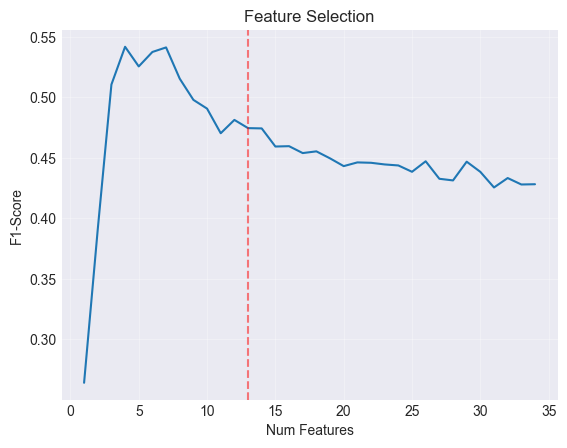

In [39]:
# plot
plt.plot(
    range(1, len(selector.cv_results_["mean_test_score"]) + 1),
    selector.cv_results_["mean_test_score"],
)
plt.xlabel("Num Features")
plt.ylabel("F1-Score")
plt.title("Feature Selection")
plt.axvline(
    x=selector.n_features_,
    color="r",
    linestyle="--",
    alpha=0.5,
)
plt.legend()
plt.grid(alpha=0.3)

### Train Model

In [30]:
# # Select optimal features
# X_train_optimal = X_train[optimal_features]
# X_test_optimal = X_test[optimal_features]
X_train_optimal = selector.transform(X_train)  # reduce x to features
X_test_optimal = selector.transform(X_test)

rf_clf = RandomForestClassifier(
    **random_search.best_params_,
    n_jobs=-1,
)

# fit
rf_clf.fit(X_train_optimal, y_train)

,n_estimators,1000
,criterion,'log_loss'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,128
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Model Performance

In [31]:
cv_scores = cross_val_score(
    rf_clf, X_train_optimal, y_train, cv=cv, scoring="f1_weighted", n_jobs=-1
)

print(f"CV F1-weighted scores: {cv_scores}")
print(f"Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Also get other metrics via cross_validate
scoring = {
    "f1_weighted": "f1_weighted",
    "f1_macro": "f1_macro",
    "balanced_accuracy": "balanced_accuracy",
    "precision_weighted": "precision_weighted",
    "recall_weighted": "recall_weighted",
}

cv_results = cross_validate(
    rf_clf, X_train_optimal, y_train, cv=cv, scoring=scoring, n_jobs=-1
)

print("\nCross-Validation Metrics:")
for score in scoring.keys():
    scores = cv_results[f"test_{score}"]
    print(f"{score} {scores.mean():.3f} (+/- {scores.std() * 2:.2f})")

CV F1-weighted scores: [0.63284823 0.68070438 0.54695104 0.60129288 0.59452098]
Mean: 0.6113 (+/- 0.0886)

Cross-Validation Metrics:
f1_weighted 0.613 (+/- 0.09)
f1_macro 0.588 (+/- 0.10)
balanced_accuracy 0.574 (+/- 0.10)
precision_weighted 0.620 (+/- 0.09)
recall_weighted 0.617 (+/- 0.09)


In [32]:
# Make predictions on test set
y_pred = rf_clf.predict(X_test_optimal)
y_prob = rf_clf.predict_proba(X_test_optimal)
y_true = y_test

In [33]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average="macro")
f1_weighted = f1_score(y_true, y_pred, average="weighted")

print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1-Score (Macro):  {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Per-class metrics
print("\vClassification Report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[f"{int(cluster)}" for cluster in np.unique(y_true)],
    )
)

Balanced Accuracy: 0.5663
F1-Score (Macro):  0.5899
F1-Score (Weighted): 0.6107
Classification Report:
              precision    recall  f1-score   support

           4       0.60      0.79      0.68        98
          13       0.60      0.57      0.59        47
          21       0.63      0.47      0.54        40
          24       0.64      0.52      0.57        56
          32       0.69      0.48      0.56        23

    accuracy                           0.62       264
   macro avg       0.63      0.57      0.59       264
weighted avg       0.62      0.62      0.61       264



### Error Analysis

In [34]:
# Analyze misclassifications
misclassified_mask = y_pred != y_true
n_misclassified = misclassified_mask.sum()

print(
    f"Misclassifications: {n_misclassified} / {len(y_true)} ({n_misclassified / len(y_true) * 100:.1f}%)"
)

# Get misclassified examples with their probabilities
misclassified_indices = np.where(misclassified_mask)[0]
misclassified_df = pd.DataFrame(
    {
        # "index": misclassified_indices,
        "true_class": y_true.iloc[misclassified_indices].values,
        "pred_class": y_pred[misclassified_indices],
        "confidence": y_prob[misclassified_indices].max(axis=1),
    }
)

misclassified_df.sort_values(by="confidence", ascending=False).head(10)


Misclassifications: 101 / 264 (38.3%)


,true_class,pred_class,confidence
18,24,32,0.597789
55,24,4,0.537060
3,13,4,0.460506
15,13,4,0.441479
76,4,13,0.441042
89,32,4,0.435072
39,13,4,0.426115
30,21,4,0.415958
68,24,4,0.413413
34,24,4,0.409244


Mean confidence (correct): 0.410
Mean confidence (incorrect): 0.328


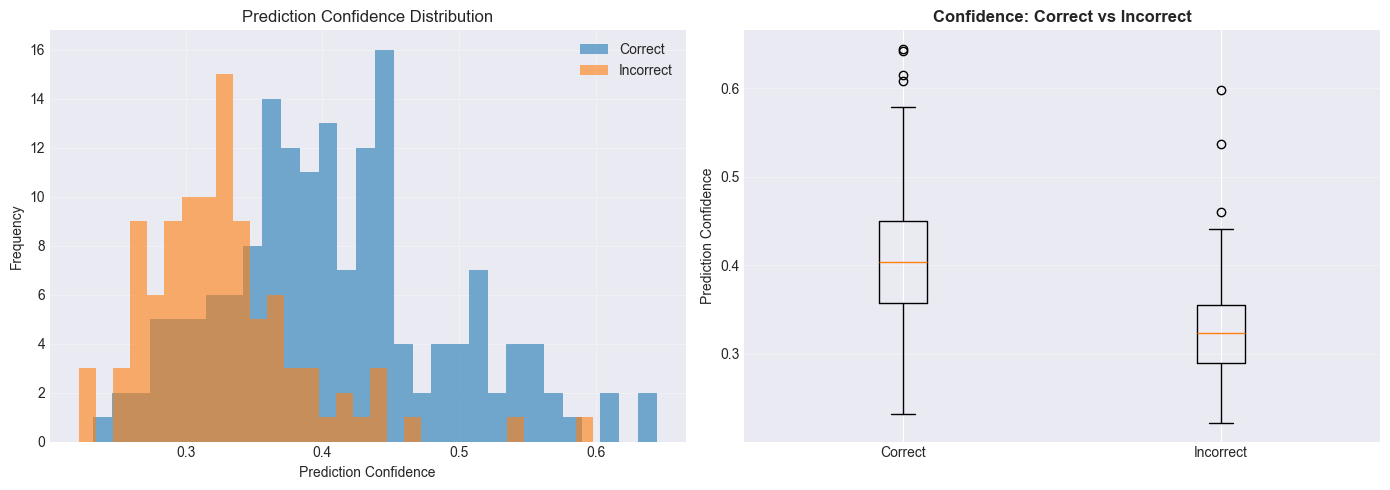

In [35]:
# Analyze prediction confidence
confidence_correct = y_prob[~misclassified_mask].max(axis=1)
confidence_wrong = y_prob[misclassified_mask].max(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of confidence scores
ax = axes[0]
ax.hist(confidence_correct, bins=30, alpha=0.6, label="Correct")  
ax.hist(confidence_wrong, bins=30, alpha=0.6, label="Incorrect")  
ax.set_xlabel("Prediction Confidence")
ax.set_ylabel("Frequency")
ax.set_title("Prediction Confidence Distribution")
ax.legend()
ax.grid(alpha=0.3)

# Box plot of confidence by correctness
axes[1].boxplot(
    [confidence_correct, confidence_wrong],
    tick_labels=["Correct", "Incorrect"],
)
axes[1].set_ylabel("Prediction Confidence")
axes[1].set_title("Confidence: Correct vs Incorrect", fontweight="bold")
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()

print(f"Mean confidence (correct): {confidence_correct.mean():.3f}")
print(f"Mean confidence (incorrect): {confidence_wrong.mean():.3f}")

### Save Model 

In [36]:
# Save the trained model
import joblib

model_path = PROJECT_DIR / "models" / "random_forest_tuned.pkl"
model_path.parent.mkdir(exist_ok=True, parents=True)

joblib.dump(rf_clf, model_path)

['c:\\Users\\ayahu\\git\\flights\\models\\random_forest_tuned.pkl']

In [ ]:
# Save features
features_path = PROJECT_DIR / "models" / "selected_features.json"
with open(features_path, "w") as fp:
    json.dump(list(optimal_features), fp)

# LightGBM Model

In [ ]:
import lightgbm as lgb

# LightGBM dataset format
train_data = lgb.Dataset(X_train_optimal, label=y_train)
test_data  = lgb.Dataset(X_test_optimal,  label=y_test)

# Number of unique classes
num_classes = len(np.unique(y_train))


params = {
    "objective": "multiclass",
    "num_class": num_classes,
    "metric": "multi_logloss",
    "learning_rate": 0.02,     
    "num_leaves": 128, 
    "max_depth": -1,  
    "min_data_in_leaf": 20,
    "feature_fraction": 0.85,
    "bagging_fraction": 0.85, 
    "bagging_freq": 5,
    "lambda_l2": 3.0, 
    "is_unbalance": True,
    "verbose": -1
}

lgbmodel = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=3000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)] 
)



Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	training's multi_logloss: 0.0450213	valid_1's multi_logloss: 1.13345


In [47]:
# Predict probabilities and convert to label predictions
y_pred_proba = lgbmodel.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Macro F1 recommended for multiclass imbalance
f1 = f1_score(y_test, y_pred, average="macro")

print("Accuracy:", acc)
print("Macro F1:", f1)


Accuracy: 0.5151515151515151
Macro F1: 0.45795005720096216


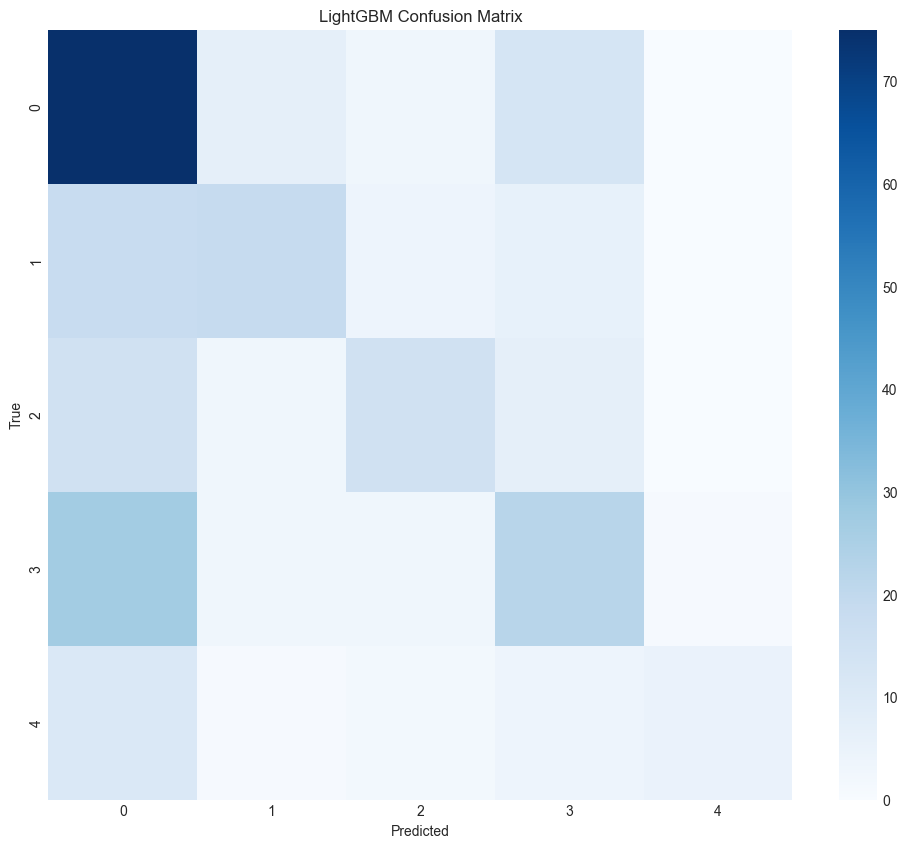

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


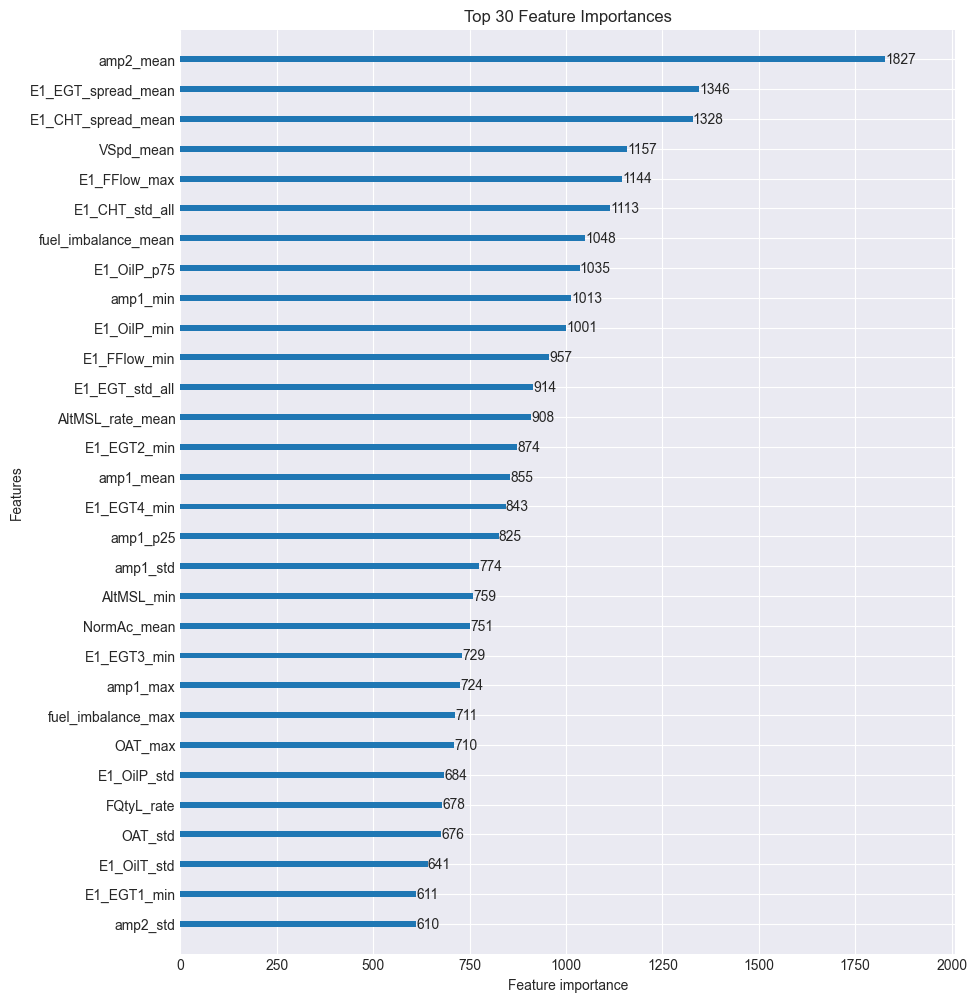

In [49]:
lgb.plot_importance(lgbmodel, max_num_features=30, figsize=(10, 12))
plt.title("Top 30 Feature Importances")
plt.show()
